## Ноутбук: OVR CatBoost по MCC-категориям и анализ результатов

В этом ноутбуке собраны три основных шага решения:

1. **Признаки уровня “клиент–период–категория”**  
   Используются заранее подготовленные фичи для каждой тройки *(client_pin_hash, period_start, cat_id)*:
   - 7 базовых признаков поведения клиента в данной категории за последние 30 дней;
   - дополнительные признаки клиента: возраст, сегмент, день недели.

2. **Обучение ансамбля CatBoost по схеме one-vs-rest**  
   Для каждой из 32 категорий обучается отдельная бинарная модель `CatBoostClassifier`, предсказывающая вероятность того, что категория войдёт в целевое множество для данного клиента и периода.

3. **Подбор порогов, инференс и анализ**  
   - для каждой категории подбирается свой порог по вероятности, чтобы:
     - сохранить разумную долю положительных срабатываний (близкую к доле «1» в данных),
     - улучшить взвешенную Hamming/Jaccard-подобную метрику;
   - на тесте формируется финальный сабмит по всем 32 категориям;
   - добавляется простое правило **safety-top1** на уровне строки;
   - по сохранённым моделям строится тепловая карта важности признаков и таблица метрик по категориям.

---

### Модель CatBoost и используемые параметры

Во всех экспериментах используется `CatBoostClassifier` в схеме one-vs-rest (OVR):  
**одна модель на одну категорию**.

Основные параметры:

- `RANDOM_STATE = 42`  

- `CLIENT_FRAC_P = 30`  
  В обучение берётся только часть клиентов (примерно 30 % по хэшу `client_pin_hash`).  
  Это ускоряет эксперименты, позволяет не упираться в лимиты по памяти и дает скор, сопоставимый  с большим объемом данных.

- `VAL_SIZE = 0.15`, `TEST_SIZE = 0.15`  
  Разбиение по клиентам:
  - сначала: **train+val** vs **internal test** (15 % клиентов в test),
  - затем: деление train+val на **train** и **validation** так, чтобы итоговые доли были примерно 70/15/15 (по клиентам).

- `CATBOOST_ITERS = 1200`  
  Верхняя граница числа деревьев. Фактическое количество обычно меньше за счёт `use_best_model=True` и ранней остановки по валидационной выборке.

- `CATBOOST_DEPTH = 7`  
  Глубина деревьев. 

- `LEARNING_RATE = 0.06`  
  Шаг градиентного бустинга. 

- `TASK_TYPE = "GPU"`, `USED_RAM_LIMIT = "20gb"`  
  Обучение на GPU с ограничением по памяти, чтобы сильно не раздувать потребление ресурсов.

- `SAFETY_TOP1 = True`  
  Включает постобработку предсказаний: если у строки все 32 категории получились «0», то принудительно включается категория `supermarkety` как наиболее универсальная и массовая.

---

### Признаки и таргет на уровне “клиент–период–категория”

Для каждой строки уровня *(клиент, период, категория)* используются:

**7 базовых признаков по категории за 30 дней:**

- `f1_amount_share_30d` — доля суммы транзакций в этой категории от общей суммы всех транзакций клиента за последние 30 дней;
- `f2_days_since_last_cat` — число дней с момента последней транзакции в данной категории;
- `f3_halfdays_since_any` — число 12-часовых интервалов с момента последней транзакции клиента в любой категории;
- `f4_sum_amt_cat_30d` — суммарная сумма транзакций по категории за 30 дней;
- `f5_cnt_cat_30d` — количество транзакций по категории за 30 дней;
- `f6_cnt_share_30d` — доля количества транзакций в категории от общего количества транзакций клиента за 30 дней;
- `f7_is_morning` — бинарный индикатор «утреннего» периода (1 — утро, 0 — всё остальное).

**Дополнительные признаки клиента:**

- `dow_idx` — день недели (0–6), вычисленный по дате `period_start` (например, 0 — воскресенье);
- `age` — возраст клиента, агрегированный по исходным данным (средний возраст по клиенту; пропуски заполняются медианой по данной категории);
- `seg` — клиентский сегмент (категориальный признак; пропуски заменяются на `'unknown'`).

**Таргет:**

- В исходном train-датасете у каждой строки есть вектор `target` из 32 бинарных значений.
- Для категории с индексом `k` берётся компонент `y = list_extract(target, k+1)` и используется как бинарный таргет для модели этой категории.

### Подбор порога для каждой категории

CatBoost выдаёт для каждой строки и категории **вероятность** того, что таргет равен 1.  
Чтобы получить бинарный ответ, для каждой категории нужен свой порог `thr[k]`, а не универсальные `0.5`.

Подбор порога делится на два шага:

#### 1. Инициализация порога по доле единиц (prevalence-init)

На валидационной выборке для одной категории:

1. Считаем **долю единиц** в таргете:
   - `prev = mean(y_val)` — насколько часто эта категория реально встречается.
2. Берём **распределение предсказанных вероятностей** `p_val` и выбираем начальный порог `T0` как квантиль уровня  
   `q = 1 − prev` (ограниченный в диапазоне `[0.01, 0.99]`):
   - если категория редкая (мало единиц), то `prev` маленький → `q` близко к 1 → порог получается высоким;
   - если категория встречается часто, `prev` больше → `q` ниже → порог уменьшается.
3. В итоге доля объектов, у которых `p_val ≥ T0`, получается **сопоставимой с долей единиц** в данных.  
   То есть стартовый порог примерно **сохраняет истинную долю “1” по этой категории**.

Это даёт «разумную» отправную точку без перебора всех возможных порогов.

#### 2. Уточнение порога вокруг T0 по взвешенной Hamming-метрике

Дальше порог слегка докручивается вокруг `T0`, чтобы улучшить метрику, похожую на соревновательную:

1. Строим **сетку порогов** в окне `[T0 − THR_SPAN, T0 + THR_SPAN]` (обрезая в [0, 1])  
   и берём несколько (например, 15) равномерных значений.
2. Для каждого кандидата `t`:
   - считаем бинарные предсказания `y_pred = (p_val ≥ t)`,
   - вычисляем **взвешенный Hamming-скор** `hamming_score_weighted(y_val, y_pred, weight_k)`,  
     где `weight_k` — вес данной категории из условия соревнования.
3. Выбираем порог `t`, дающий лучший скор.  
   Процедуру делаем 1–2 раза (несколько «проходов»), пока качество перестаёт улучшаться.

Таким образом:

- на шаге 1 порог грубо калибруется **по распределению вероятностей**, чтобы не ломать реальную долю срабатываний по категории;
- на шаге 2 порог **слегка подстраивается** под целевую метрику, используя веса категорий из соревнования.


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''
!kaggle competitions download -c alfa-predict-next-transactions-set

 97%|████████████████████████████████████▋ | 1.51G/1.56G [00:01<00:00, 1.25GB/s]
100%|██████████████████████████████████████| 1.56G/1.56G [00:01<00:00, 1.23GB/s]


In [ ]:
import pandas as pd
import os, sys, json, gc, warnings, math
from pathlib import Path
import numpy as np
import pandas as pd
import duckdb
from catboost import CatBoostClassifier, Pool  
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import precision_recall_fscore_support

warnings.filterwarnings("ignore")


import zipfile
with zipfile.ZipFile('/kaggle/working/alfa-predict-next-transactions-set.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/unzipped')


In [ ]:
# ---------------- CONFIG ----------------
RANDOM_STATE   = 42
CLIENT_FRAC_P  = 30       
VAL_SIZE       = 0.15
TEST_SIZE      = 0.15
CATBOOST_ITERS = 1200
CATBOOST_DEPTH = 7
LEARNING_RATE  = 0.06
USED_RAM_LIMIT = "20gb"
TASK_TYPE      = "GPU"

SAFETY_TOP1    = True
THR_ROUNDS     = 2
THR_SPAN       = 0.25
THR_GRID_PTS   = 15

# базовые 7 признаков 
feat_cols_base = [
    "f1_amount_share_30d","f2_days_since_last_cat","f3_halfdays_since_any",
    "f4_sum_amt_cat_30d","f5_cnt_cat_30d","f6_cnt_share_30d","f7_is_morning"
]
# признаки возраста age (число), дня недели dow_idx (0..6) и сегмента (категориальный)
extra_num = ["age", "dow_idx"]     
extra_cat = ["seg"]                  
feat_cols_all = feat_cols_base + extra_num + extra_cat

cats = [
    'alkogol','arenda_avto','avto','azs','blagotvoritelnost','dom_i_remont','fastfud',
    'juvelirnye_izdelija','kafe_i_restorany','knigi','kommunalnye_uslugi','krasota','kredity',
    'obrazovanie','odezhda_i_obuv','prochie_rashody','puteshestvija','razvlechenija','sber_ecosystem',
    'shtrafy_i_nalogi','sportivnye_tovary','supermarkety','svjaz_internet_i_tv','tabak','taksi',
    'tehnika','transport','tsifrovye_tovary','tsvety','yandex_ecosystem','zdorove','zhivotnye'
]
weights = np.array([
    0.37,0.66,0.41,0.34,0.63,0.39,0.24,0.72,0.38,0.50,0.57,0.45,0.68,
    0.62,0.41,0.35,0.52,0.38,0.52,0.55,0.60,0.08,0.47,0.45,0.50,0.52,0.26,0.41,0.49,0.28,0.33,0.53
], dtype=np.float32)

n_cats  = len(cats)
cat2idx = {c:i for i,c in enumerate(cats)}

In [ ]:

# ---------------- METRICS ----------------
def hamming_score_weighted(y_true, y_pred, category_weights=None):
    n_samples, n_classes = y_true.shape
    if category_weights is None:
        category_weights = np.ones(n_classes, dtype=float)
    else:
        category_weights = np.asarray(category_weights, dtype=float)
    inter = (y_true & y_pred).astype(np.float32)
    uni   = (y_true | y_pred).astype(np.float32)
    wi = (inter * category_weights.reshape(1, -1)).sum(axis=1)
    wu = (uni   * category_weights.reshape(1, -1)).sum(axis=1)
    both_zero = (y_true.sum(axis=1) == 0) & (y_pred.sum(axis=1) == 0)
    score = np.where(wu > 0, wi / np.maximum(wu, 1e-12), 1.0)
    score = np.where(both_zero, 1.0, score)
    return float(score.mean())

def prf_from_probs(y_true, probs, thr):
    y_pred = (probs >= thr).astype(np.uint8)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return float(p), float(r), float(f1)

# --- thresholds: init by prevalence, then coordinate ascent (weighted Hamming) ---
def init_thresholds_by_prevalence(P_val, Y_val):
    prev = Y_val.mean(axis=0)
    ts = []
    for k in range(P_val.shape[1]):
        q = float(1.0 - prev[k])                   # квантиль по «редкости» класса
        q = min(max(q, 0.01), 0.99)
        ts.append(np.quantile(P_val[:, k], q))
    return np.array(ts, dtype=np.float32)

def coordinate_descent_hamming(P_val, Y_val, weights, T_init, rounds=2, grid_points=15, span=0.25):
    T = T_init.astype(np.float32).copy()
    best_pred = (P_val >= T.reshape(1,-1)).astype(np.uint8)
    best_score = hamming_score_weighted(Y_val, best_pred, weights)
    for r in range(rounds):
        improved = False
        for k in range(P_val.shape[1]):
            t0 = T[k]
            lo = max(0.0, t0 - span); hi = min(1.0, t0 + span)
            grid = np.linspace(lo, hi, grid_points)
            base_col = best_pred[:, k].copy()
            best_k_t = t0; best_k_score = best_score
            for t in grid:
                cand_col = (P_val[:, k] >= t).astype(np.uint8)
                best_pred[:, k] = cand_col
                sc = hamming_score_weighted(Y_val, best_pred, weights)
                if sc > best_k_score + 1e-8:
                    best_k_score = sc; best_k_t = t
            if best_k_t != t0:
                T[k] = best_k_t
                best_score = best_k_score
                best_pred[:, k] = (P_val[:, k] >= best_k_t).astype(np.uint8)
                improved = True
            else:
                best_pred[:, k] = base_col
        print(f"[coord-ascent {r+1}/{rounds}] weighted Hamming={best_score:.4f}")
        if not improved:
            break
    return T


In [ ]:
# ---------------- PATHS ----------------

OUTDIR = Path("/kaggle/working/best/feat7_cb"); OUTDIR.mkdir(parents=True, exist_ok=True)

def find_under_input(filename):
    base = Path("/kaggle/input")
    for p in base.rglob(filename):
        return p
    return None

FEAT_TRAIN = find_under_input("train_feat7_all.parquet")
FEAT_TEST  = find_under_input("test_feat7_all.parquet")
if FEAT_TRAIN is None or FEAT_TEST is None:
    raise FileNotFoundError("Нет train_feat7_all.parquet / test_feat7_all.parquet в /kaggle/input/**")

ROOT = Path("/kaggle/working/unzipped")
TRAIN_FILES = []
if (ROOT/"train/train_1.parquet").exists(): TRAIN_FILES.append((ROOT/"train/train_1.parquet").as_posix())
if (ROOT/"train/train_2.parquet").exists(): TRAIN_FILES.append((ROOT/"train/train_2.parquet").as_posix())
if not TRAIN_FILES:
    cand = list(Path("/kaggle/input").rglob("train_1.parquet"))
    if cand: TRAIN_FILES.append(cand[0].as_posix())
    cand2 = list(Path("/kaggle/input").rglob("train_2.parquet"))
    if cand2: TRAIN_FILES.append(cand2[0].as_posix())
if not TRAIN_FILES:
    raise FileNotFoundError("Не нашёл train_*.parquet для восстановления y и профилей")
TRAIN_LIST_SQL = "[" + ",".join(f"'{p}'" for p in TRAIN_FILES) + "]"

TEST_CSV = (ROOT / "test.csv")
if not TEST_CSV.exists():
    t = list(Path("/kaggle/input").rglob("test.csv"))
    if t: TEST_CSV = t[0]
if not TEST_CSV.exists():
    raise FileNotFoundError("Не найден test.csv")

In [ ]:
# ---------------- DUCKDB ----------------
con = duckdb.connect(database=':memory:',
    config={"threads":"2","preserve_insertion_order":"false","temp_directory":"/kaggle/temp"})
con.execute("SET memory_limit='16GB';")

# выберем долю клиентов
con.execute(f"""
CREATE TEMP TABLE sel_clients AS
SELECT client_pin_hash AS cid
FROM (
  SELECT DISTINCT client_pin_hash, ABS(hash(client_pin_hash)) % 100 AS shard
  FROM read_parquet({TRAIN_LIST_SQL})
) t
WHERE shard < {CLIENT_FRAC_P};
""")
n_sel = con.execute("SELECT COUNT(*) FROM sel_clients;").fetchone()[0]
print(f"Selected clients (~{CLIENT_FRAC_P}%):", n_sel)

# ### NEW: построим клиентский профиль (age, segment) из train_* и будем подтягивать и в train, и в test
con.execute(f"""
CREATE TEMP TABLE raw_prof AS
SELECT
  client_pin_hash AS cid,
  TRY_CAST(age AS DOUBLE)          AS age,
  lower(clientsegment)             AS seg
FROM read_parquet({TRAIN_LIST_SQL});
""")

# агрегируем возраст (средний по клиенту) и берём модальный сегмент
con.execute("""
CREATE TEMP TABLE prof_age AS
SELECT cid, AVG(age) AS age
FROM raw_prof
WHERE age IS NOT NULL
GROUP BY cid;
""")
con.execute("""
CREATE TEMP TABLE prof_seg_top AS
WITH cnt AS (
  SELECT cid, seg, COUNT(*) AS c
  FROM raw_prof
  WHERE seg IS NOT NULL
  GROUP BY cid, seg
),
ranked AS (
  SELECT cid, seg, c,
         ROW_NUMBER() OVER (PARTITION BY cid ORDER BY c DESC, seg) AS rn
  FROM cnt
)
SELECT cid, seg
FROM ranked
WHERE rn = 1;
""")
con.execute("""
CREATE TEMP TABLE client_profile AS
SELECT COALESCE(a.cid, s.cid) AS cid,
       a.age,
       s.seg
FROM prof_age a
FULL OUTER JOIN prof_seg_top s ON a.cid = s.cid;
""")

# --------- ОБУЧЕНИЕ ПО КАТЕГОРИЯМ -----------
models = {}
thr = np.full(n_cats, 0.5, dtype=np.float32)
per_cat_metrics = []
age_median_per_cat = {}  

for cat, k in cat2idx.items():
    print(f"\n=== Train category: {cat} (id={k}) ===")
    df_cat = con.execute(f"""
    WITH tr_raw AS (
      SELECT client_pin_hash AS cid,
             CAST(period_start AS TIMESTAMP) AS ts,
             lower(day_period) AS dp,
             target
      FROM read_parquet({TRAIN_LIST_SQL})
    ),
    tr AS (
      SELECT *
      FROM tr_raw
      QUALIFY ROW_NUMBER() OVER (PARTITION BY cid, ts, dp ORDER BY ts) = 1
    )
    SELECT
      ft.client_pin_hash                        AS cid,
      CAST(ft.period_start AS TIMESTAMP)        AS ts,
      lower(ft.day_period)                      AS dp,
      -- базовые 7 фичей
      {", ".join("ft."+c for c in feat_cols_base)},
      -- ### NEW: dow_idx из ts (0..6), age и segment из client_profile
      CAST(strftime('%w', CAST(ft.period_start AS TIMESTAMP)) AS INTEGER) AS dow_idx,
      prof.age                                               AS age,
      COALESCE(prof.seg, 'unknown')                          AS seg,
      -- таргет k-й метки
      COALESCE(CAST(list_extract(tr.target, {k+1}) AS INTEGER), 0)        AS y
    FROM read_parquet('{FEAT_TRAIN.as_posix()}') AS ft
    JOIN sel_clients s    ON s.cid = ft.client_pin_hash
    JOIN tr               ON tr.cid = ft.client_pin_hash
                         AND tr.ts  = CAST(ft.period_start AS TIMESTAMP)
                         AND tr.dp  = lower(ft.day_period)
    LEFT JOIN client_profile prof ON prof.cid = ft.client_pin_hash
    WHERE ft.cat_id = {k};
    """).fetch_df()

    if df_cat.empty:
        print("…skip (no rows)"); continue

    # типы и заполнение пропусков
    df_cat["seg"] = df_cat["seg"].astype(str).fillna("unknown")
    age_median = float(np.nanmedian(df_cat["age"].to_numpy(np.float32))) if df_cat["age"].notna().any() else 0.0
    df_cat["age"] = df_cat["age"].fillna(age_median).astype(np.float32)
    df_cat["dow_idx"] = df_cat["dow_idx"].fillna(0).astype(np.int16)
    age_median_per_cat[k] = age_median

    # группы по клиентам
    groups = df_cat["cid"].astype(str).values
    y      = df_cat["y"].to_numpy(np.uint8)

    # сплиты по клиентам
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    idx_trv, idx_te = next(gss.split(df_cat[feat_cols_all], y, groups=groups))
    df_trv, df_te = df_cat.iloc[idx_trv], df_cat.iloc[idx_te]
    y_trv,  y_te  = y[idx_trv], y[idx_te]
    groups_trv    = groups[idx_trv]

    gss2 = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE/(1.0-TEST_SIZE), random_state=RANDOM_STATE)
    idx_tr, idx_va = next(gss2.split(df_trv[feat_cols_all], y_trv, groups=groups_trv))
    df_tr, df_va = df_trv.iloc[idx_tr], df_trv.iloc[idx_va]
    y_tr,  y_va  = y_trv[idx_tr], y_trv[idx_va]

    # CatBoost: числовые + 1 категориальная ('seg')
    cat_idx = [feat_cols_all.index("seg")]
    pool_tr = Pool(df_tr[feat_cols_all], label=y_tr, cat_features=cat_idx)
    pool_va = Pool(df_va[feat_cols_all], label=y_va, cat_features=cat_idx)
    pool_te = Pool(df_te[feat_cols_all], label=y_te, cat_features=cat_idx)

    pos = int(y_tr.sum()); neg = len(y_tr) - pos
    cw = None
    if pos > 0 and neg > 0:
        pos_w = ((neg / max(pos,1)) ** 0.5) * float(weights[k]) * 2.0
        pos_w = float(min(50.0, max(1.0, pos_w)))
        cw = [1.0, pos_w]

    model = CatBoostClassifier(
        loss_function="Logloss",
        depth=CATBOOST_DEPTH,
        iterations=CATBOOST_ITERS,
        learning_rate=LEARNING_RATE,
        eval_metric="AUC",
        random_seed=RANDOM_STATE,
        verbose=False,
        class_weights=cw,
        used_ram_limit=USED_RAM_LIMIT,
        allow_writing_files=True,
        task_type=TASK_TYPE,
        train_dir=str(OUTDIR / f"cb_cat{k}_tmp")
    )
    model.fit(pool_tr, eval_set=pool_va, use_best_model=True)
    models[k] = model

    # --- Валидационные вероятности и подгон порога ---
    p_va = model.predict_proba(pool_va)[:,1]
    # prevalence-init:
    prev = float(y_va.mean())
    T0   = float(np.quantile(p_va, min(0.99, max(0.01, 1.0 - prev))))
    # координатный подъём для одного класса (просто уточним T0 вокруг):
    Tt = coordinate_descent_hamming(
        p_va.reshape(-1,1), y_va.reshape(-1,1), np.array([weights[k]]),
        np.array([T0], dtype=np.float32),
        rounds=THR_ROUNDS, grid_points=THR_GRID_PTS, span=THR_SPAN
    )[0]
    thr[k] = float(Tt)

    P_va, R_va, F1_va = prf_from_probs(y_va, p_va, thr[k])
    print(f"val: prev={prev:.4f}  T0={T0:.3f} → thr={thr[k]:.3f} | P={P_va:.3f} R={R_va:.3f} F1={F1_va:.3f}  (pos={pos}, neg={neg})")

    # --- Внутренний тест ---
    p_te = model.predict_proba(pool_te)[:,1]
    yhat_te = (p_te >= thr[k]).astype(np.uint8)
    j_te = hamming_score_weighted(y_te.reshape(-1,1), yhat_te.reshape(-1,1), np.array([weights[k]]))
    P_te, R_te, F1_te = prf_from_probs(y_te, p_te, thr[k])
    print(f"test: Jaccard={j_te:.3f} | P={P_te:.3f} R={R_te:.3f} F1={F1_te:.3f} | rows={len(y_te)}")

    per_cat_metrics.append({
        "cat": cat, "k": k, "thr": float(thr[k]),
        "val_P": P_va, "val_R": R_va, "val_F1": F1_va,
        "test_P": P_te, "test_R": R_te, "test_F1": F1_te,
        "train_pos": pos, "train_neg": neg, "prev_val": prev, "T0": T0
    })

    # --- ### NEW: Сохраним вероятности и ключи (для «развлечений») ---
    def save_probs(df_keys, probs, labels, split_name):
        out_df = pd.DataFrame({
            "cid": df_keys["cid"].astype(str).values,
            "ts":  pd.to_datetime(df_keys["ts"]).values.astype("datetime64[ns]"),
            "dp":  df_keys["dp"].astype(str).values,
            "cat_id": k,
            "p": probs.astype(np.float32),
            "y": labels.astype(np.uint8)
        })
        out_path = OUTDIR / f"{split_name}_probs_cat{k}.parquet"
        out_df.to_parquet(out_path, index=False)
    save_probs(df_va[["cid","ts","dp"]], p_va, y_va, "val")
    save_probs(df_te[["cid","ts","dp"]], p_te, y_te, "test")

    # модель
    model.save_model(str(OUTDIR / f"cb_cat{k}.cbm"))

    # уборка
    del df_cat, df_trv, df_te, df_tr, df_va, y, y_trv, y_te, y_tr, y_va, pool_tr, pool_va, pool_te, p_va, p_te
    gc.collect()

# сводка
dfm = pd.DataFrame(per_cat_metrics).sort_values("val_F1")
dfm.to_csv(OUTDIR / "per_cat_metrics.csv", index=False)
np.save(OUTDIR / "thresholds.npy", thr)
with open(OUTDIR / "cats.json", "w", encoding="utf-8") as f:
    json.dump(cats, f, ensure_ascii=False)
print("\n== Worst 10 by val_F1 ==")
print(dfm[["k","cat","val_F1","val_P","val_R","thr","train_pos","train_neg","prev_val","T0"]].head(10).to_string(index=False))

# ---------------- INFERENCE on test_feat7_all.parquet ----------------
# подготовим таблицу клиентских профилей (age, seg) доступную и для теста
# (мы уже создали client_profile из train_*)

con.execute("""
CREATE TEMP TABLE preds_all (
  cid VARCHAR, ts TIMESTAMP, dp VARCHAR, cat_id INTEGER, pred INTEGER
);
""")

for k in range(n_cats):
    if k not in models:
        con.execute(f"""
        INSERT INTO preds_all
        SELECT client_pin_hash, CAST(period_start AS TIMESTAMP), lower(day_period), {k}, 0
        FROM read_parquet('{FEAT_TEST.as_posix()}')
        WHERE cat_id = {k};
        """)
        continue

    # заберём признаки для теста, включая новые
    df_t = con.execute(f"""
    SELECT
      ft.client_pin_hash                         AS cid,
      CAST(ft.period_start AS TIMESTAMP)         AS ts,
      lower(ft.day_period)                       AS dp,
      {", ".join("ft."+c for c in feat_cols_base)},
      CAST(strftime('%w', CAST(ft.period_start AS TIMESTAMP)) AS INTEGER) AS dow_idx,
      prof.age                                   AS age,
      COALESCE(prof.seg, 'unknown')              AS seg
    FROM read_parquet('{FEAT_TEST.as_posix()}') AS ft
    LEFT JOIN client_profile prof ON prof.cid = ft.client_pin_hash
    WHERE ft.cat_id = {k};
    """).fetch_df()

    if df_t.empty:
        continue

    # заполнение пропусков так же, как при обучении
    df_t["seg"] = df_t["seg"].astype(str).fillna("unknown")
    df_t["age"] = df_t["age"].fillna(age_median_per_cat.get(k, 0.0)).astype(np.float32)
    df_t["dow_idx"] = df_t["dow_idx"].fillna(0).astype(np.int16)

    cat_idx = [feat_cols_all.index("seg")]
    pool_t = Pool(df_t[feat_cols_all], cat_features=cat_idx)
    p = models[k].predict_proba(pool_t)[:,1]
    yhat = (p >= thr[k]).astype(np.int8)

    out = pd.DataFrame({"cid": df_t["cid"].astype(str),
                        "ts": pd.to_datetime(df_t["ts"]).values.astype("datetime64[ns]"),
                        "dp": df_t["dp"].astype(str),
                        "cat_id": k, "pred": yhat})
    con.register("tmp_pred", out)
    con.execute("INSERT INTO preds_all SELECT * FROM tmp_pred;")
    con.unregister("tmp_pred")

    # (опция) можно сохранить и инференс-вероятности:
    pd.DataFrame({
        "cid": df_t["cid"].astype(str),
        "ts":  pd.to_datetime(df_t["ts"]).values.astype("datetime64[ns]"),
        "dp":  df_t["dp"].astype(str),
        "cat_id": k,
        "p": p.astype(np.float32)
    }).to_parquet(OUTDIR / f"testinf_probs_cat{k}.parquet", index=False)

    del df_t, pool_t, p, yhat, out
    gc.collect()

# wide
wide_sel = ", ".join([f"MAX(CASE WHEN cat_id={i} THEN pred END) AS {cats[i]}" for i in range(n_cats)])
con.execute(f"CREATE TEMP TABLE preds_wide AS SELECT cid, ts, dp, {wide_sel} FROM preds_all GROUP BY 1,2,3;")

# восстановим порядок как в test.csv
test_csv = pd.read_csv(TEST_CSV)
test_csv["cid"] = test_csv["client_pin_hash"].astype(str)
test_csv["ts"]  = pd.to_datetime(test_csv["period_start"])
test_csv["dp"]  = test_csv["day_period"].astype(str).str.lower()
test_csv["row_id"] = np.arange(len(test_csv), dtype=np.int64)
con.register("test_csv", test_csv)

cols_join = ", ".join([f"COALESCE(w.{c}, 0) AS {c}" for c in cats])
pred_joined = con.execute(f"""
SELECT t.row_id, {cols_join}
FROM test_csv t
LEFT JOIN preds_wide w
  ON w.cid = t.cid AND w.ts = t.ts AND w.dp = t.dp
ORDER BY t.row_id;
""").fetch_df()
con.unregister("test_csv")

# safety-top1 (упрощённый): если все нули — включим 'supermarkety'
if SAFETY_TOP1:
    arr = pred_joined[cats].to_numpy(np.int8)
    zero = np.where(arr.sum(axis=1) == 0)[0]
    if len(zero) > 0:
        arr[zero, cat2idx['supermarkety']] = 1
        for i, c in enumerate(cats): pred_joined[c] = arr[:, i]

submission = pred_joined[cats].astype(int)
submission.insert(0, "id", np.arange(len(submission), dtype=int))
sub_path = "/kaggle/working/best/submission_best.csv"
submission.to_csv(sub_path, index=False)
print("\n✅ Saved submission:", sub_path)

print("Artifacts in:", OUTDIR)
#   - thresholds.npy
#   - per_cat_metrics.csv
#   - cb_cat{k}.cbm
#   - val_probs_cat{k}.parquet / test_probs_cat{k}.parquet / testinf_probs_cat{k}.parquet


Features train: /kaggle/input/datafeature/train_feat7_all.parquet
Features test : /kaggle/input/datafeature/test_feat7_all.parquet
Train files   : ['/kaggle/working/unzipped/train/train_1.parquet', '/kaggle/working/unzipped/train/train_2.parquet']
Test CSV      : /kaggle/working/unzipped/test.csv
Selected clients (~30%): 133693


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== Train category: alkogol (id=0) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9588
[coord-ascent 2/2] weighted Hamming=0.9589
val: prev=0.0434  T0=0.500 → thr=0.786 | P=0.644 R=0.117 F1=0.198  (pos=314721, neg=6974006)
test: Jaccard=0.960 | P=0.641 R=0.121 F1=0.204 | rows=1564841

=== Train category: arenda_avto (id=1) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9952
[coord-ascent 2/2] weighted Hamming=0.9977
val: prev=0.0026  T0=0.515 → thr=0.965 | P=0.636 R=0.190 F1=0.293  (pos=17402, neg=7271325)
test: Jaccard=0.998 | P=0.690 R=0.233 F1=0.348 | rows=1564841

=== Train category: avto (id=2) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9750
[coord-ascent 2/2] weighted Hamming=0.9754
val: prev=0.0249  T0=0.450 → thr=0.807 | P=0.681 R=0.021 F1=0.040  (pos=180041, neg=7108686)
test: Jaccard=0.976 | P=0.597 R=0.019 F1=0.037 | rows=1564841

=== Train category: azs (id=3) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9504
[coord-ascent 2/2] weighted Hamming=0.9507
val: prev=0.0499  T0=0.411 → thr=0.733 | P=0.596 R=0.035 F1=0.067  (pos=368310, neg=6920417)
test: Jaccard=0.949 | P=0.558 R=0.026 F1=0.049 | rows=1564841

=== Train category: blagotvoritelnost (id=4) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9951
[coord-ascent 2/2] weighted Hamming=0.9971
val: prev=0.0031  T0=0.511 → thr=0.965 | P=0.697 R=0.086 F1=0.153  (pos=21621, neg=7267106)
test: Jaccard=0.997 | P=0.596 R=0.047 F1=0.087 | rows=1564841

=== Train category: dom_i_remont (id=5) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9695
[coord-ascent 2/2] weighted Hamming=0.9706
val: prev=0.0295  T0=0.394 → thr=0.787 | P=0.553 R=0.015 F1=0.029  (pos=215779, neg=7072948)
test: Jaccard=0.970 | P=0.530 R=0.012 F1=0.024 | rows=1564841

=== Train category: fastfud (id=6) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.8320
[coord-ascent 2/2] weighted Hamming=0.8320
val: prev=0.1830  T0=0.295 → thr=0.509 | P=0.653 R=0.175 F1=0.276  (pos=1328311, neg=5960416)
test: Jaccard=0.833 | P=0.654 R=0.182 F1=0.284 | rows=1564841

=== Train category: juvelirnye_izdelija (id=7) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9983
[coord-ascent 2/2] weighted Hamming=0.9991
val: prev=0.0008  T0=0.136 → thr=0.636 | P=0.080 R=0.017 F1=0.028  (pos=5729, neg=7282998)
test: Jaccard=0.999 | P=0.096 R=0.023 F1=0.037 | rows=1564841

=== Train category: kafe_i_restorany (id=8) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9544
[coord-ascent 2/2] weighted Hamming=0.9550
val: prev=0.0460  T0=0.429 → thr=0.786 | P=0.644 R=0.048 F1=0.089  (pos=327885, neg=6960842)
test: Jaccard=0.954 | P=0.649 R=0.052 F1=0.097 | rows=1564841

=== Train category: knigi (id=9) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9914
[coord-ascent 2/2] weighted Hamming=0.9928
val: prev=0.0072  T0=0.371 → thr=0.871 | P=0.520 R=0.057 F1=0.102  (pos=49863, neg=7238864)
test: Jaccard=0.993 | P=0.668 R=0.068 F1=0.124 | rows=1564841

=== Train category: kommunalnye_uslugi (id=10) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9959
[coord-ascent 2/2] weighted Hamming=0.9963
val: prev=0.0037  T0=0.470 → thr=0.970 | P=0.000 R=0.000 F1=0.000  (pos=29767, neg=7258960)
test: Jaccard=0.996 | P=0.750 R=0.000 F1=0.001 | rows=1564841

=== Train category: krasota (id=11) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9838
[coord-ascent 2/2] weighted Hamming=0.9845
val: prev=0.0155  T0=0.364 → thr=0.864 | P=0.500 R=0.002 F1=0.004  (pos=107943, neg=7180784)
test: Jaccard=0.985 | P=0.442 R=0.005 F1=0.009 | rows=1564841

=== Train category: kredity (id=12) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9949
[coord-ascent 2/2] weighted Hamming=0.9978
val: prev=0.0004  T0=0.084 → thr=0.584 | P=0.076 R=0.376 F1=0.126  (pos=4376, neg=7284351)
test: Jaccard=0.997 | P=0.080 R=0.439 F1=0.136 | rows=1564841

=== Train category: obrazovanie (id=13) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9961
[coord-ascent 2/2] weighted Hamming=0.9981
val: prev=0.0019  T0=0.379 → thr=0.879 | P=0.485 R=0.081 F1=0.139  (pos=14095, neg=7274632)
test: Jaccard=0.998 | P=0.477 R=0.084 F1=0.143 | rows=1564841

=== Train category: odezhda_i_obuv (id=14) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9809
[coord-ascent 2/2] weighted Hamming=0.9815
val: prev=0.0185  T0=0.311 → thr=0.811 | P=0.425 R=0.001 F1=0.002  (pos=130745, neg=7157982)
test: Jaccard=0.981 | P=0.437 R=0.001 F1=0.002 | rows=1564841

=== Train category: prochie_rashody (id=15) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9680
[coord-ascent 2/2] weighted Hamming=0.9693
val: prev=0.0316  T0=0.372 → thr=0.801 | P=0.680 R=0.049 F1=0.092  (pos=227161, neg=7061566)
test: Jaccard=0.971 | P=0.664 R=0.044 F1=0.083 | rows=1564841

=== Train category: puteshestvija (id=16) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9935
[coord-ascent 2/2] weighted Hamming=0.9943
val: prev=0.0058  T0=0.467 → thr=0.931 | P=0.703 R=0.011 F1=0.021  (pos=42161, neg=7246566)
test: Jaccard=0.994 | P=0.691 R=0.011 F1=0.021 | rows=1564841

=== Train category: razvlechenija (id=17) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9674
[coord-ascent 2/2] weighted Hamming=0.9686
val: prev=0.0334  T0=0.382 → thr=0.775 | P=0.669 R=0.121 F1=0.205  (pos=236113, neg=7052614)
test: Jaccard=0.970 | P=0.652 R=0.110 F1=0.188 | rows=1564841

=== Train category: sber_ecosystem (id=18) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9899
[coord-ascent 2/2] weighted Hamming=0.9899
val: prev=0.0102  T0=0.726 → thr=0.904 | P=0.607 R=0.049 F1=0.090  (pos=73043, neg=7215684)
test: Jaccard=0.990 | P=0.577 R=0.062 F1=0.111 | rows=1564841

=== Train category: shtrafy_i_nalogi (id=19) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9941
[coord-ascent 2/2] weighted Hamming=0.9955
val: prev=0.0045  T0=0.423 → thr=0.923 | P=0.419 R=0.004 F1=0.009  (pos=32520, neg=7256207)
test: Jaccard=0.996 | P=0.567 R=0.026 F1=0.050 | rows=1564841

=== Train category: sportivnye_tovary (id=20) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9961
[coord-ascent 2/2] weighted Hamming=0.9970
val: prev=0.0030  T0=0.323 → thr=0.823 | P=0.385 R=0.001 F1=0.002  (pos=21230, neg=7267497)
test: Jaccard=0.997 | P=0.108 R=0.001 F1=0.002 | rows=1564841

=== Train category: supermarkety (id=21) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.7189
[coord-ascent 2/2] weighted Hamming=0.7189
val: prev=0.6510  T0=0.597 → thr=0.490 | P=0.735 R=0.889 F1=0.805  (pos=4747196, neg=2541531)
test: Jaccard=0.721 | P=0.737 R=0.890 F1=0.806 | rows=1564841

=== Train category: svjaz_internet_i_tv (id=22) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9917
[coord-ascent 2/2] weighted Hamming=0.9923
val: prev=0.0080  T0=0.519 → thr=0.897 | P=0.680 R=0.058 F1=0.106  (pos=60423, neg=7228304)
test: Jaccard=0.992 | P=0.676 R=0.055 F1=0.101 | rows=1564841

=== Train category: tabak (id=23) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9811
[coord-ascent 2/2] weighted Hamming=0.9814
val: prev=0.0188  T0=0.530 → thr=0.832 | P=0.568 R=0.038 F1=0.071  (pos=140729, neg=7147998)
test: Jaccard=0.981 | P=0.549 R=0.041 F1=0.076 | rows=1564841

=== Train category: taksi (id=24) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9879
[coord-ascent 2/2] weighted Hamming=0.9879
val: prev=0.0136  T0=0.764 → thr=0.899 | P=0.654 R=0.226 F1=0.336  (pos=101578, neg=7187149)
test: Jaccard=0.988 | P=0.697 R=0.302 F1=0.421 | rows=1564841

=== Train category: tehnika (id=25) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9927
[coord-ascent 2/2] weighted Hamming=0.9934
val: prev=0.0065  T0=0.271 → thr=0.771 | P=0.271 R=0.008 F1=0.016  (pos=47756, neg=7240971)
test: Jaccard=0.993 | P=0.350 R=0.010 F1=0.020 | rows=1564841

=== Train category: transport (id=26) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9026
[coord-ascent 2/2] weighted Hamming=0.9026
val: prev=0.1300  T0=0.418 → thr=0.560 | P=0.688 R=0.459 F1=0.551  (pos=944457, neg=6344270)
test: Jaccard=0.905 | P=0.694 R=0.467 F1=0.559 | rows=1564841

=== Train category: tsifrovye_tovary (id=27) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9888
[coord-ascent 2/2] weighted Hamming=0.9890
val: prev=0.0120  T0=0.556 → thr=0.873 | P=0.686 R=0.152 F1=0.249  (pos=87077, neg=7201650)
test: Jaccard=0.990 | P=0.710 R=0.146 F1=0.242 | rows=1564841

=== Train category: tsvety (id=28) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9934
[coord-ascent 2/2] weighted Hamming=0.9940
val: prev=0.0060  T0=0.244 → thr=0.744 | P=0.229 R=0.001 F1=0.002  (pos=42989, neg=7245738)
test: Jaccard=0.994 | P=0.210 R=0.002 F1=0.005 | rows=1564841

=== Train category: yandex_ecosystem (id=29) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9392
[coord-ascent 2/2] weighted Hamming=0.9392
val: prev=0.0726  T0=0.472 → thr=0.650 | P=0.665 R=0.329 F1=0.440  (pos=524349, neg=6764378)
test: Jaccard=0.940 | P=0.657 R=0.328 F1=0.438 | rows=1564841

=== Train category: zdorove (id=30) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9381
[coord-ascent 2/2] weighted Hamming=0.9388
val: prev=0.0613  T0=0.285 → thr=0.713 | P=0.561 R=0.003 F1=0.006  (pos=435094, neg=6853633)
test: Jaccard=0.939 | P=0.556 R=0.005 F1=0.009 | rows=1564841

=== Train category: zhivotnye (id=31) ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Default metric period is 5 because AUC is/are not implemented for GPU


[coord-ascent 1/2] weighted Hamming=0.9921
[coord-ascent 2/2] weighted Hamming=0.9926
val: prev=0.0074  T0=0.490 → thr=0.954 | P=0.000 R=0.000 F1=0.000  (pos=52603, neg=7236124)
test: Jaccard=0.993 | P=0.000 R=0.000 F1=0.000 | rows=1564841

== Worst 10 by val_F1 ==
 k                cat   val_F1    val_P    val_R      thr  train_pos  train_neg  prev_val       T0
10 kommunalnye_uslugi 0.000000 0.000000 0.000000 0.969617      29767    7258960  0.003663 0.469617
31          zhivotnye 0.000000 0.000000 0.000000 0.954206      52603    7236124  0.007445 0.489920
20  sportivnye_tovary 0.002146 0.384615 0.001076 0.822997      21230    7267497  0.002985 0.322997
28             tsvety 0.002352 0.229167 0.001182 0.744305      42989    7245738  0.005978 0.244305
14     odezhda_i_obuv 0.002358 0.425000 0.001182 0.810546     130745    7157982  0.018476 0.310546
11            krasota 0.003706 0.500000 0.001860 0.863606     107943    7180784  0.015546 0.363606
30            zdorove 0.006071 0.560694 0

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


✅ Saved submission: /kaggle/working/best/submission_best.csv
Artifacts in: /kaggle/working/best/feat7_cb


# Пункт 5: важность фичей и метрики по модели для каждой категории

## 5.1 Анализ важности фичей

In [ ]:
import re, json
import matplotlib.pyplot as plt

In [18]:
TOP_FEATS    = 10                 

cats_json = OUTDIR / "cats.json"
pvt_csv   = OUTDIR / "feature_importances_heatmap.csv"
png_path  = OUTDIR / f"feature_importances_heatmap_top{TOP_FEATS}.png"

# ---- 1) Считываем/строим сводную таблицу важностей ----
def build_pivot_from_models(art_dir: Path) -> pd.DataFrame:
    # найдём модели cb_cat{k}.cbm по возрастанию k
    cbm_files = sorted(
        art_dir.glob("cb_cat*.cbm"),
        key=lambda p: int(re.search(r"cb_cat(\d+)\.cbm", p.name).group(1))
                      if re.search(r"cb_cat(\d+)\.cbm", p.name) else 10**9
    )
    if not cbm_files:
        raise FileNotFoundError(f"Не нашёл моделей cb_cat*.cbm в {art_dir}")

    # подписи категорий (если есть)
    if cats_json.exists():
        with open(cats_json, "r", encoding="utf-8") as f:
            cats = json.load(f)
    else:
        cats = None

    rows = []
    for cbm in cbm_files:
        m = re.search(r"cb_cat(\d+)\.cbm", cbm.name)
        if not m:
            continue
        k = int(m.group(1))
        cat_name = cats[k] if (cats and k < len(cats)) else f"cat_{k}"

        model = CatBoostClassifier()
        model.load_model(cbm.as_posix())

        feat_names = model.feature_names_
        if not feat_names:
            raise RuntimeError(f"У модели {cbm.name} отсутствуют feature_names_. "
                               f"Нужны имена фичей из обучения (feat_cols_all).")

        imp = np.array(model.get_feature_importance(type='FeatureImportance'), dtype=float)
        if len(imp) != len(feat_names):
            raise ValueError(f"Длина importances ({len(imp)}) != числу фичей ({len(feat_names)}) для {cbm.name}")

        s = imp.sum()
        norm = imp / s if s > 0 else np.zeros_like(imp)

        for f, v in zip(feat_names, norm):
            rows.append({"feature": f, "category": cat_name, "norm_importance": float(v)})

    df = pd.DataFrame(rows)
    pvt = df.pivot_table(index="feature", columns="category", values="norm_importance",
                         aggfunc="sum", fill_value=0.0)
    # Отсортируем фичи по среднему важности (по всем категориям)
    pvt["__mean__"] = pvt.mean(axis=1)
    pvt = pvt.sort_values("__mean__", ascending=False).drop(columns="__mean__")
    return pvt

if pvt_csv.exists():
    pvt = pd.read_csv(pvt_csv, index_col=0)
else:
    pvt = build_pivot_from_models(OUTDIR)
    # на будущее сохраним сводку
    pvt.to_csv(pvt_csv)

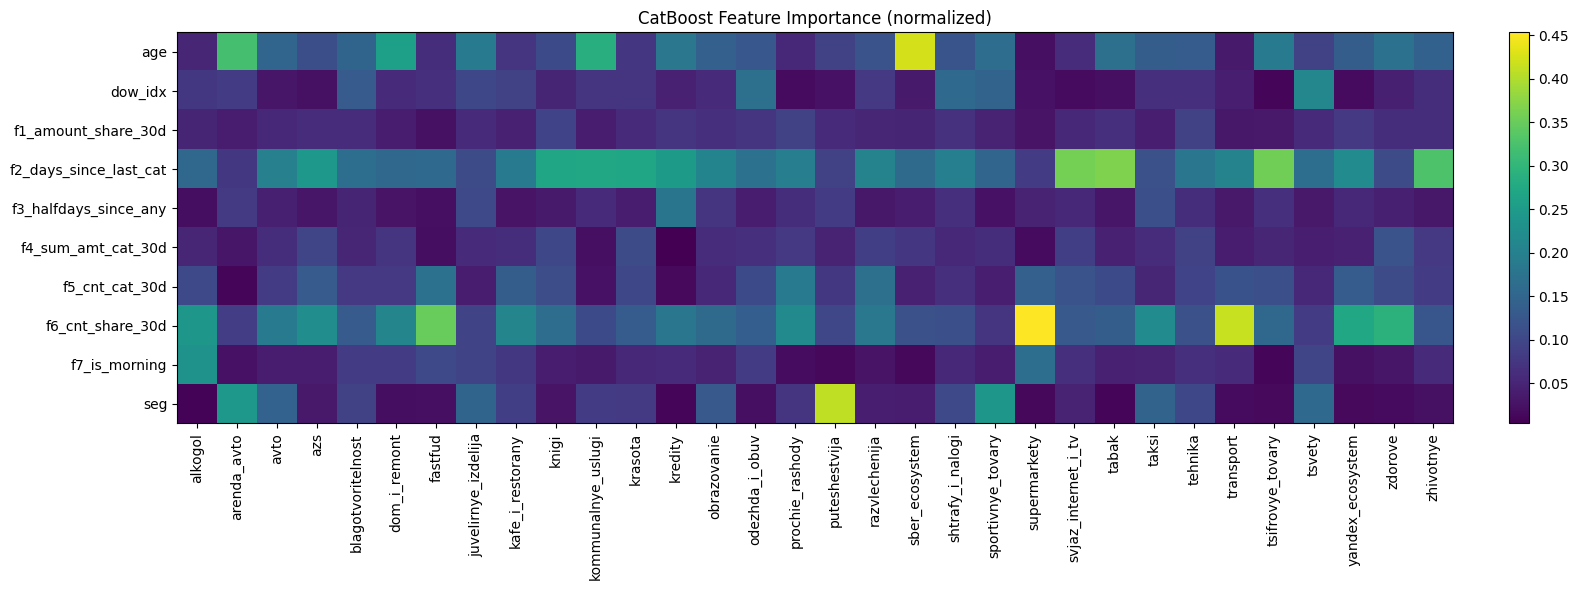

In [19]:
# ---- 2) Рисуем heatmap ----
pvt_top = pvt.head(TOP_FEATS)

plt.figure(figsize=(max(10, pvt_top.shape[1] * 0.5), max(6, TOP_FEATS * 0.4)))  # авто-размер под число колонок/строк
im = plt.imshow(pvt_top.values, aspect="auto")   # не задаём colormap вручную
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.yticks(ticks=np.arange(pvt_top.shape[0]), labels=pvt_top.index)
plt.xticks(ticks=np.arange(pvt_top.shape[1]), labels=pvt_top.columns, rotation=90)
plt.title(f"CatBoost Feature Importance (normalized)")
plt.tight_layout()
plt.savefig(png_path, dpi=200)
plt.show()


## Выводы важности признаков

Выше приведена матрица важности признаков CatBoost (нормированная по столбцам: сумма важностей по каждой категории равна 1). По ней и по табличным значениям можно сделать несколько наблюдений.

1. **Наиболее универсальные признаки — «свежесть» и интенсивность категории.**  
   В большинстве категорий в топ-3 по важности попадают:
   - `f2_days_since_last_cat` — время с последней операции по категории;
   - `f6_cnt_share_30d` и `f5_cnt_cat_30d` — доля и количество операций за 30 дней.  
   Это подтверждает, что для задачи критично, *насколько недавно и регулярно* клиент пользовался категорией.

2. **Возраст и сегмент важны для «профильных» категорий.**  
   Признаки `age` и `seg` входят в число ведущих для категорий:
   `arenda_avto`, `kredity`, `kommunalnye_uslugi`, `sber_ecosystem`, `sportivnye_tovary`,  
   `puteshestvija`, `tehnika` и др.  
   Здесь поведение клиента существенно зависит от демографии и сегмента (кредитные и коммунальные платежи, аренда авто, экосистемные сервисы и т.п.).

3. **День недели (`dow_idx`) влияет на категории с выраженной календарной цикличностью.**  
   Высокая важность `dow_idx` наблюдается, например, для `odezhda_i_obuv`, `tsvety`,  
   `blagotvoritelnost`, `shtrafy_i_nalogi`. Это логично: часть расходов приурочена к выходным, праздникам, датам оплаты счетов.

4. **Часть дня (`f7_is_morning`) важна для повседневных категорий.**  
   Для `fastfud`, `supermarkety`, `transport`, `kafe_i_restorany` и ряда других категорий признак `f7_is_morning` входит в число значимых.  
   Разделение на утренние/неутренние периоды помогает лучше ловить типичные сценарии (дорога на работу, утренние покупки и т.п.).

5. **Сумма и доля суммы по категории играют поддерживающую роль.**  
   Признаки `f1_amount_share_30d` и `f4_sum_amt_cat_30d` редко оказываются первыми по важности, но стабильно присутствуют в середине рейтинга для большинства категорий.  
   Они уточняют картину, когда частота уже зафиксировала сам факт регулярного использования категории.

В целом, результаты по важности признаков согласуются с интуицией:  
модель в первую очередь опирается на *давность и частоту* использования категории, затем — на демографику и календарные эффекты (день недели и часть дня).


## 5.2 Качество по отдельным категориям

In [16]:
per_cat_metrics = OUTDIR / "per_cat_metrics.csv"

metrics_df = pd.read_csv(per_cat_metrics)

metrics_df = metrics_df[["cat", "k", "test_P", "test_R", "test_F1"]]

metrics_df = metrics_df.rename(columns={
    "test_P": "precision",
    "test_R": "recall",
    "test_F1": "f1"
})

metrics_df.sort_values("f1", ascending=False).reset_index(drop=True)

,cat,k,precision,recall,f1
0,supermarkety,21,0.736627,0.889542,0.805895
1,transport,26,0.694227,0.467221,0.558540
2,yandex_ecosystem,29,0.657071,0.328055,0.437620
3,taksi,24,0.696631,0.302035,0.421376
4,arenda_avto,1,0.689831,0.232571,0.347863
5,fastfud,6,0.653781,0.181790,0.284478
6,tsifrovye_tovary,27,0.709970,0.145708,0.241792
7,alkogol,0,0.641175,0.121197,0.203860
8,razvlechenija,17,0.651796,0.109894,0.188078
9,obrazovanie,13,0.477137,0.084181,0.143113


## Выводы к качествц по отдельным категориям

Для каждой из 32 категорий считались precision, recall и F1 на отложенной выборке (без дополнительного взвешивания по категориям).

Основные наблюдения:

- **Наиболее хорошо предсказываемая категория — `supermarkety`**  
  F1 ≈ 0.81 при высокой полноте (recall ≈ 0.89) и хорошей точности.  
  Это ожидаемо: категория массовая, с большим числом примеров и устойчивыми паттернами поведения.

- **Группа категорий со средним качеством (F1 ~ 0.3–0.55):**  
  `transport`, `yandex_ecosystem`, `taksi`, `arenda_avto`, `fastfud`,  
  `tsifrovye_tovary`, `alkogol`, `razvlechenija`.  
  Для них обычно высокая точность (модель бывает «осторожной») при умеренной или низкой полноте.

- **Большинство остальных категорий имеют высокую точность и очень низкую полноту.**  
  Например, `kredity`, `knigi`, `sber_ecosystem`, `svjaz_internet_i_tv`, `kafe_i_restorany`  
  и др. — модель редко ставит им метку 1, но если ставит, то делает это достаточно уверенно.  
  Это отражает сильный дисбаланс: положительных примеров мало, и модель «боится» лишний раз прогнозировать 1.

- **Длинный хвост с совсем низким F1 (≈ 0–0.02):**  
  `sportivnye_tovary`, `odezhda_i_obuv`, `tsvety`, `kommunalnye_uslugi`, `zhivotnye` и др.  
  По ним очень мало событий, и модель практически не научилась отличать положительные примеры от отрицательных.

Веса категорий из условия соревнования (`weights`) учитываются при обучении и в расчёте итоговой соревновательной метрики, поэтому их вклад в общий скор различается.  
Однако сами значения precision/recall/F1 в таблице выше приведены без учёта этих весов, чтобы было проще интерпретировать качество по каждой отдельной категории.
